In [276]:
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.dml.color import RGBColor
from pptx.enum.text import PP_ALIGN
from modified_report_script import ETL
import datetime as dt
import logging
import time
from send_email import send_email
from warnings import filterwarnings

filterwarnings('ignore')
logging.basicConfig(filename='.log/run.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')


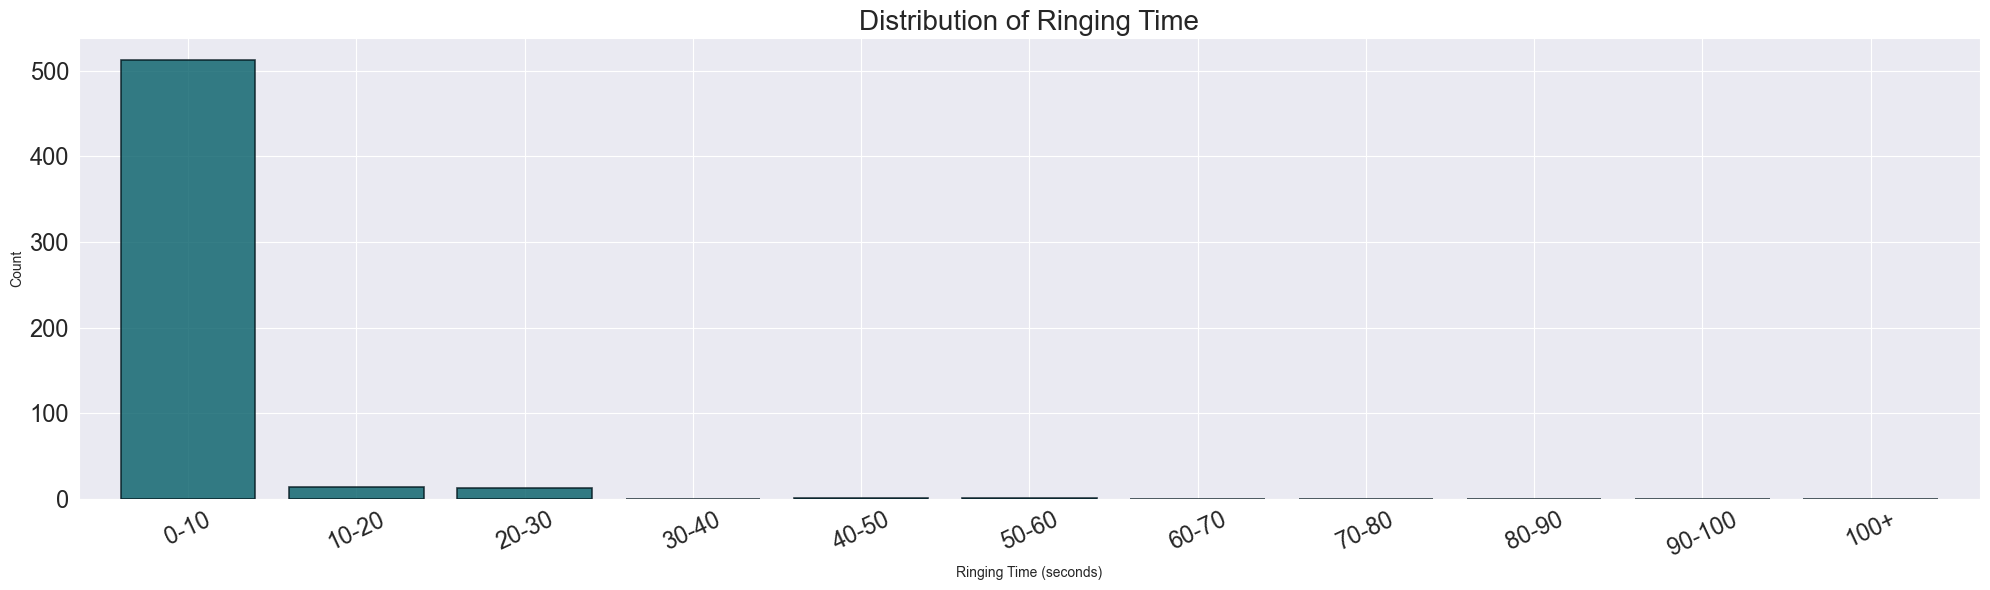

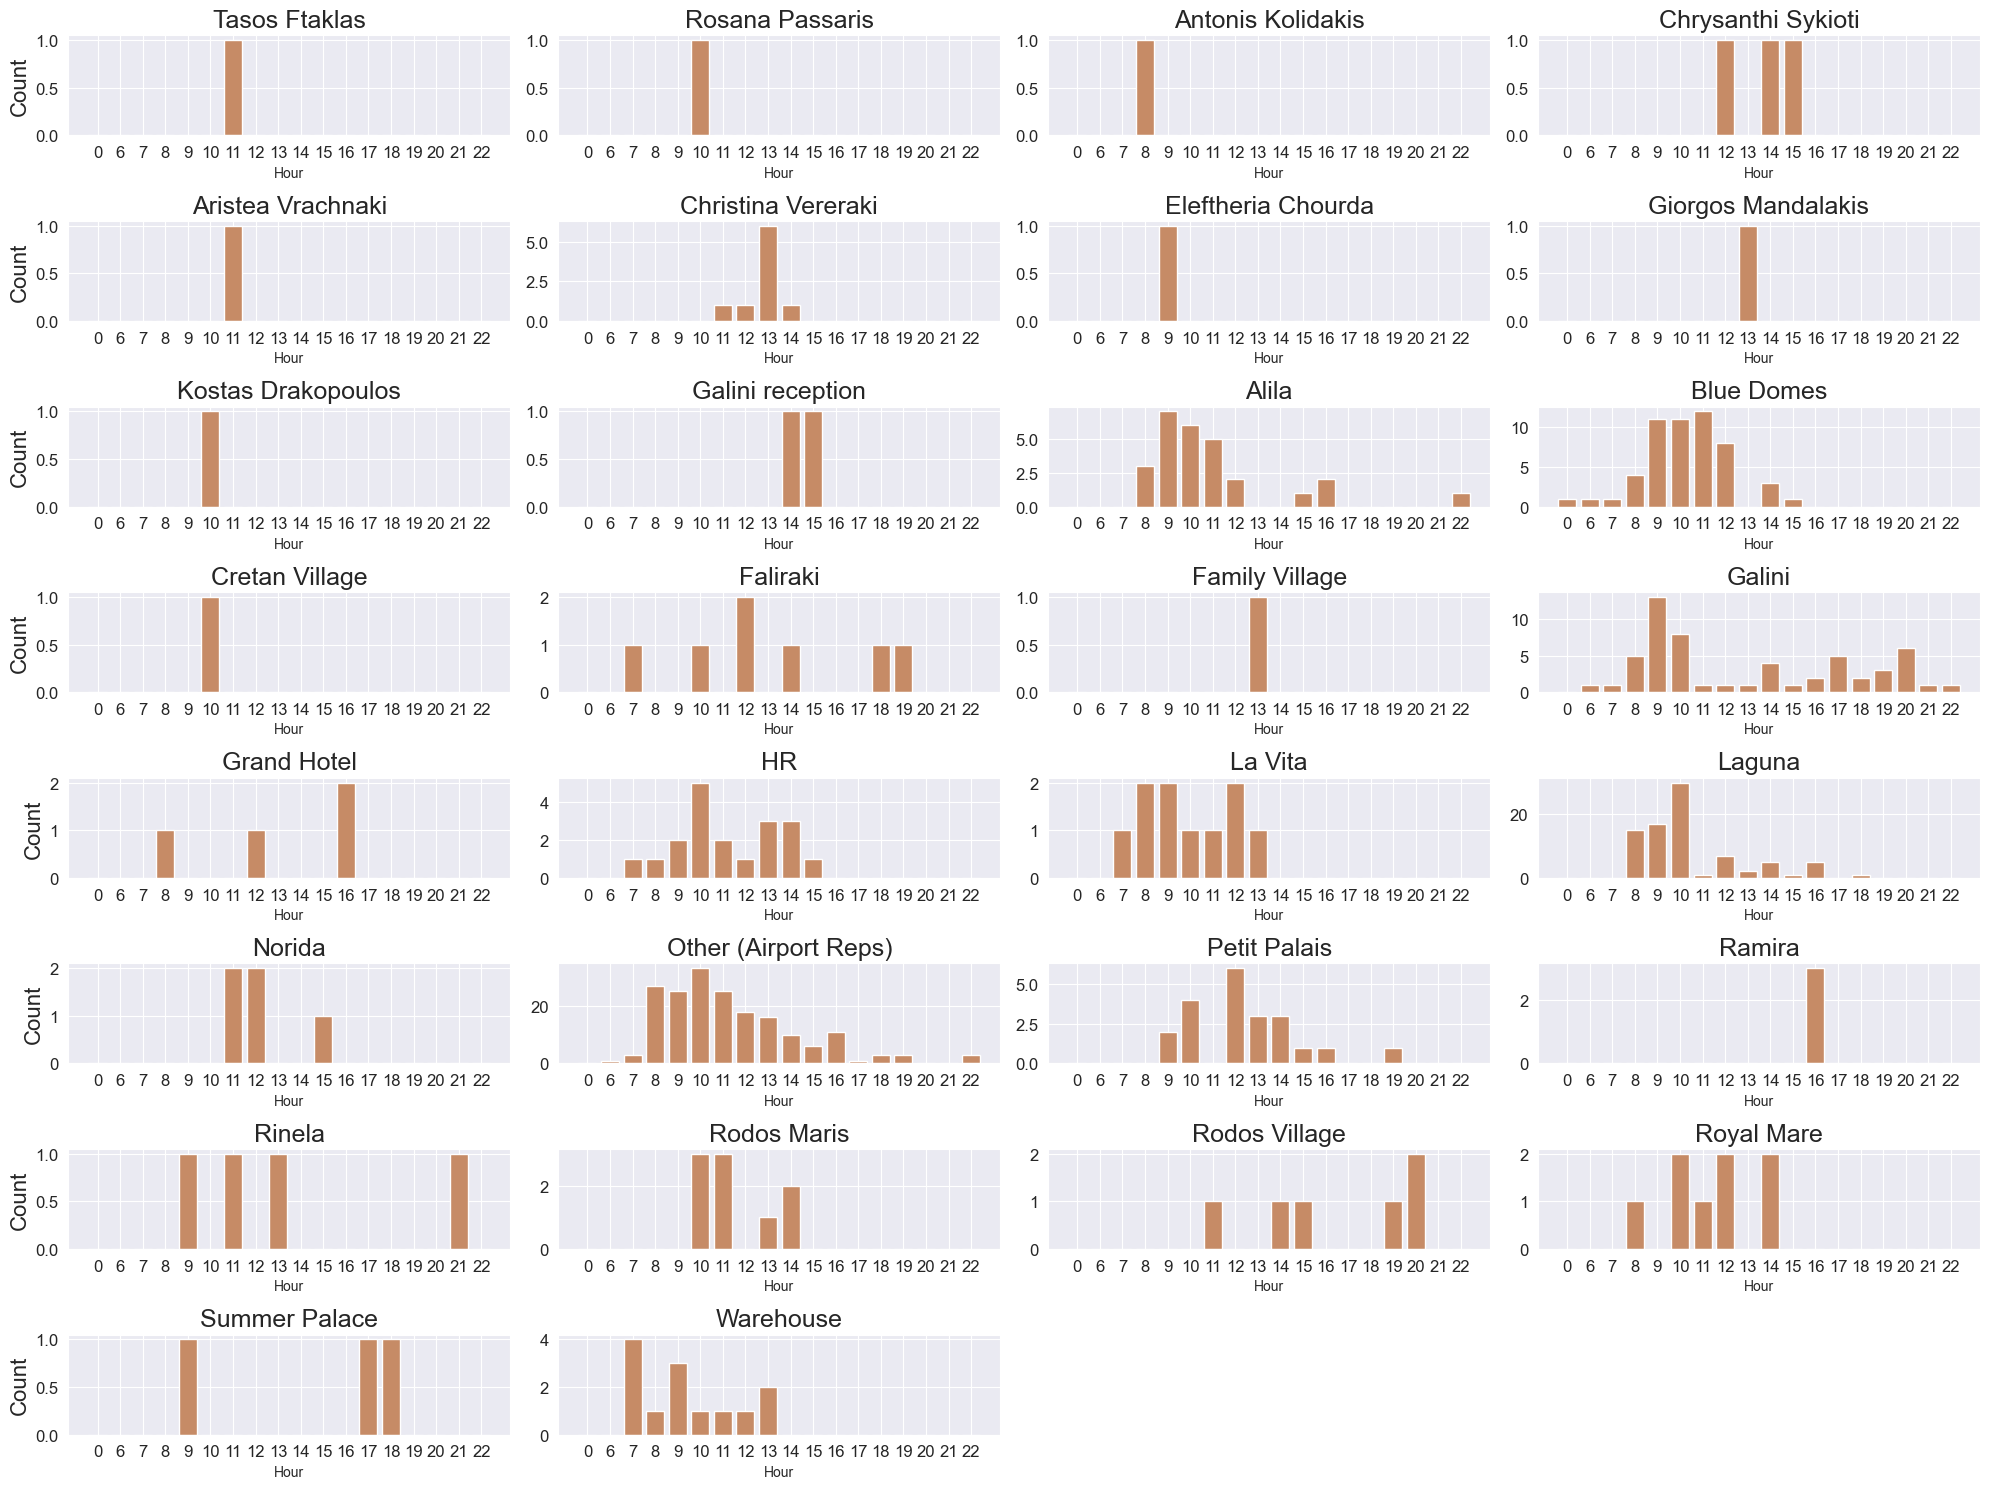

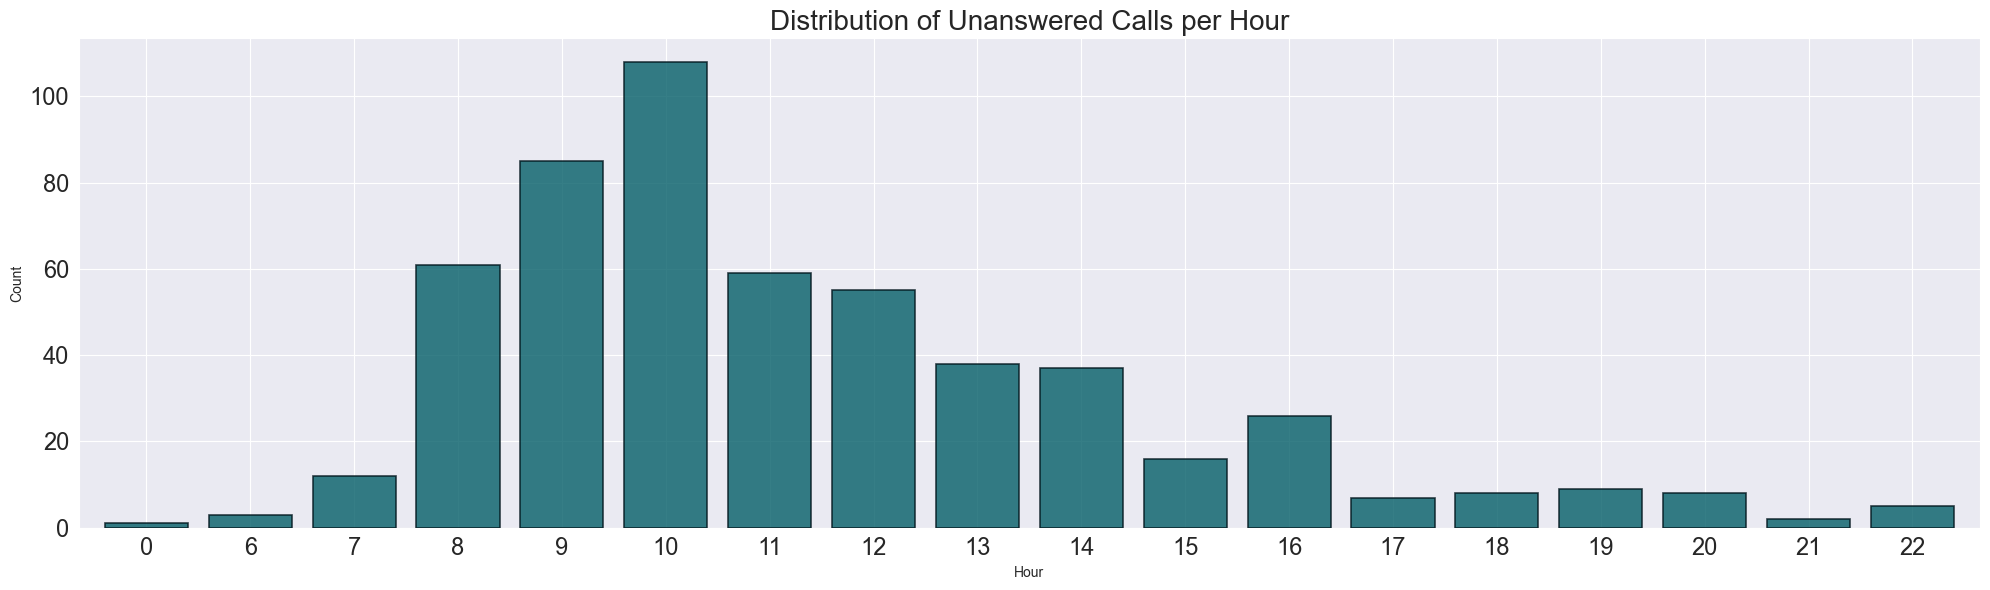

In [277]:
# Set date range
date_to = dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
date_from = (dt.datetime.now() - dt.timedelta(days=7)).strftime('%Y-%m-%d 00:00:00')

logging.info(f'Generating report for the date range: {date_from} - {date_to}')
start = time.time()

try:
    answered_df, missed_df, error_calls, agents, agents_ext, unanswered_call_counts, unanswered_calls_ring, unanswered_calls_hour = ETL(date_from, date_to)
except Exception as e:
    print(e)
    logging.error(f'Error while generating report: {e}')
    exit(1)

In [278]:
# Create PowerPoint presentation
prs = Presentation()
prs.core_properties.title = 'CloudTalk - Mitsis Group Business Analytics'
prs.core_properties.author = 'Lefteris Fthenos | Mitsis Group Business Analytics'
prs.core_properties.comments = 'This presentation was generated automatically by the CloudTalk - Mitsis Group Analytics script.'
prs.slide_layouts[5].name = 'Table Slide'

# Title slide
slide = prs.slides.add_slide(prs.slide_layouts[0])
# set background color to "00141b"
background = slide.background
fill = background.fill
fill.solid()
fill.fore_color.rgb = RGBColor(0, 20, 27)

title = slide.shapes.title
subtitle = slide.placeholders[1]

# Format title
title.text = 'CloudTalk - Mitsis Group Business Analytics'
title.text_frame.paragraphs[0].font.bold = True
title.text_frame.paragraphs[0].font.size = Pt(32)
title.text_frame.paragraphs[0].font.color.rgb = RGBColor(228, 176, 144)  # Dark blue

# Format subtitle
subtitle.text = (
    f"Date range: {dt.datetime.strptime(date_from, '%Y-%m-%d %H:%M:%S').strftime('%d/%m/%Y %H:%M')} - "
    f"{dt.datetime.strptime(date_to, '%Y-%m-%d %H:%M:%S').strftime('%d/%m/%Y %H:%M')}"
)
subtitle.text_frame.paragraphs[0].font.size = Pt(18)
subtitle.text_frame.paragraphs[0].font.color.rgb = RGBColor(146, 100, 77) 

# General statistics slide
slide = prs.slides.add_slide(prs.slide_layouts[1])
# set background color to "00141b"
background = slide.background
fill = background.fill
fill.solid()
fill.fore_color.rgb = RGBColor(0, 20, 27)
title = slide.shapes.title
bullet_points = slide.shapes.placeholders[1].text_frame

# Format slide title
title.text = 'General Statistics'
title.text_frame.paragraphs[0].font.size = Pt(28)
title.text_frame.paragraphs[0].font.bold = True
title.text_frame.paragraphs[0].font.color.rgb = RGBColor(228, 176, 144)

# Add and format bullet points
bullet_points.text = f"Total Answered calls: {len(answered_df)}"
bullet_points.paragraphs[0].font.size = Pt(16)
bullet_points.paragraphs[0].font.color.rgb = RGBColor(0, 255, 0)  # White
# increase padding
bullet_points.margin_bottom = Inches(0.5)

p1 = bullet_points.add_paragraph()
p1.text = f"Total Missed calls: {len(missed_df)}"
p1.font.size = Pt(16)
p1.font.color.rgb = RGBColor(255, 0, 0)   # Bright red

p2 = bullet_points.add_paragraph()
p2.text = f"Total Calls that failed to be retrieved through API: {error_calls}"
p2.font.size = Pt(16)
p2.font.color.rgb = RGBColor(255, 255, 255)  # Dark red

# Top agents and peak hours
top_agent = agents[agents['Answered_Calls'] == agents['Answered_Calls'].max()]['agent_name'].values[0]
top_unanswered_agent = unanswered_call_counts[unanswered_call_counts['Unanswered_UniqCount'] == unanswered_call_counts['Unanswered_UniqCount'].max()]['agent_name'].values[0]

# Handling potential non-hour entries
try:
    unanswered_calls_hour['Total'] = unanswered_calls_hour.sum(axis=1)
    top_hour = unanswered_calls_hour.loc['Total'].idxmax()
    top_hour_formatted = dt.datetime.strptime(str(top_hour), '%H').strftime('%H:%M')
except Exception:
    top_hour_formatted = "N/A"
    
p3 = bullet_points.add_paragraph()
p3.text = f"Top agent (answered calls): {top_agent} ({agents['Answered_Calls'].max()})"
p3.font.size = Pt(16)
p3.font.color.rgb = RGBColor(0, 255, 0) # Bright green

p4 = bullet_points.add_paragraph()
p4.text = f"Top agent (unanswered calls): {top_unanswered_agent} ({unanswered_call_counts['Unanswered_UniqCount'].max()})"
p4.font.size = Pt(16)
p4.font.color.rgb = RGBColor(255, 0, 0) # Bright red


In [279]:
def add_dataframe_to_slide(prs, title, dataframe, max_rows=16, wider_first_column=False, side_margin=0.5):
    """
    Add a table to PowerPoint slides for a given dataframe.
    Automatically splits the table across multiple slides if it overflows.
    """
    # Drop completely empty rows and columns in the dataframe
    dataframe = dataframe.dropna(how='all', axis=0)  # Drop empty rows
    dataframe = dataframe.dropna(how='all', axis=1)  # Drop empty columns

    # Split the dataframe into manageable chunks based on max_rows
    num_chunks = (len(dataframe) + max_rows - 1) // max_rows  # Calculate number of slides required

    for chunk_index in range(num_chunks):
        # Subset the dataframe for the current chunk
        start_row = chunk_index * max_rows
        end_row = min(start_row + max_rows, len(dataframe))
        subset = dataframe.iloc[start_row:end_row]

        # Create a new slide for the chunk
        slide = prs.slides.add_slide(prs.slide_layouts[5])

        # Set background color
        background = slide.background
        fill = background.fill
        fill.solid()
        fill.fore_color.rgb = RGBColor(0, 20, 27)  # Dark blue

        # Set the slide title
        slide_title = slide.shapes.title
        slide_title.text = f"{title} (Part {chunk_index + 1})"
        slide_title.text_frame.paragraphs[0].font.size = Pt(28)
        slide_title.text_frame.paragraphs[0].font.bold = True
        slide_title.text_frame.paragraphs[0].font.color.rgb = RGBColor(228, 176, 144)

        # Create the table dynamically based on the subset
        rows, cols = subset.shape
        table = slide.shapes.add_table(rows + 1, cols, Inches(side_margin), Inches(1.5), Inches(9), Inches(side_margin)).table

        # Style the table header
        for col_idx, column_name in enumerate(subset.columns):
            if col_idx == 0 and wider_first_column:
                table.columns[0].width = Inches(1)
                
            cell = table.cell(0, col_idx)
            cell.text = str(column_name).replace('_', ' ').capitalize()
            cell.text_frame.paragraphs[0].font.bold = True
            cell.text_frame.paragraphs[0].font.size = Pt(10)
            cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
            cell.fill.solid()
            cell.fill.fore_color.rgb = RGBColor(146, 100, 77)  

        # Populate the table rows
        for row_idx, (_, row) in enumerate(subset.iterrows()):  # Properly iterate over rows with index
            for col_idx, value in enumerate(row):
                cell = table.cell(row_idx + 1, col_idx)
                cell.text = str(round(value, 2)) if isinstance(value, float) else str(value)
                cell.text_frame.paragraphs[0].font.size = Pt(8)
                cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER


In [280]:
add_dataframe_to_slide(prs, '1. Agent Statistics (incl. Internal Calls)', agents.sort_values('Calls', ascending=False))
add_dataframe_to_slide(prs, '2. Agent Statistics (excl. Internal Calls)', agents_ext.sort_values('Calls', ascending=False))
unanswered_call_counts.rename(columns={'Unanswered_UniqCount': 'Unanswered Calls'}, inplace=True)
add_dataframe_to_slide(prs, '3. Unanswered Calls per Agent', unanswered_call_counts.sort_values('Unanswered Calls', ascending=False))

In [281]:
from pptx.chart.data import ChartData
from pptx.enum.chart import XL_CHART_TYPE, XL_LEGEND_POSITION
from pptx.util import Pt, Inches
from pptx.dml.color import RGBColor

# Example Data Preparation
# Assuming unanswered_calls_ring is a DataFrame
grouped_data = unanswered_calls_ring.groupby('ringing_time_pct')['ringing_time'].sum()

# Add chart slide
slide = prs.slides.add_slide(prs.slide_layouts[5])

# Set slide background color
background = slide.background
fill = background.fill
fill.solid()
fill.fore_color.rgb = RGBColor(0, 20, 27)  # Dark blue

# Add title and format it
title = slide.shapes.title
title.text = '4. Distribution of unanswered calls per ring time'
title.text_frame.paragraphs[0].font.size = Pt(28)
title.text_frame.paragraphs[0].font.bold = True
title.text_frame.paragraphs[0].font.color.rgb = RGBColor(228, 176, 144)

# Prepare chart data
chart_data = ChartData()
chart_data.categories = grouped_data.index.tolist()  # Categories
chart_data.add_series('', grouped_data.values.tolist())  # Values

# Add pie chart
x, y, cx, cy = Inches(0.5), Inches(1.5), Inches(9), Inches(5)
graphic_frame = slide.shapes.add_chart(
    chart_type=XL_CHART_TYPE.PIE,
    x=x,
    y=y,
    cx=cx,
    cy=cy,
    chart_data=chart_data
)

# Customize chart appearance
chart = graphic_frame.chart
chart.has_legend = True
chart.legend.include_in_layout = False
chart.legend.position = XL_LEGEND_POSITION.RIGHT
chart.legend.font.size = Pt(12)
chart.legend.font.color.rgb = RGBColor(255, 255, 255)  # White

# Add data labels inside the pie
plot = chart.plots[0]
plot.has_data_labels = True
data_labels = plot.data_labels
data_labels.number_format = '#,##0'  # Format numbers
data_labels.font.size = Pt(12)
data_labels.font.color.rgb = RGBColor(0, 0, 0)  # Black for readability

# Customize pie slice colors (optional)
points = plot.series[0].points
custom_colors = [
    RGBColor(79, 129, 189),  # Blue
    RGBColor(192, 80, 77),   # Red
    RGBColor(155, 187, 89),  # Green
    RGBColor(128, 100, 162)  # Purple
]

for point, color in zip(points, custom_colors):
    point.format.fill.solid()
    point.format.fill.fore_color.rgb = color


In [282]:
unanswered_calls_hour_t = unanswered_calls_hour.reset_index()
unanswered_calls_hour_t.drop(columns=['agent_id'], inplace=True)
add_dataframe_to_slide(prs, '5. Unanswered Calls per Hour', unanswered_calls_hour_t.sort_values(by="Total", ascending=False), max_rows=16, wider_first_column=True, side_margin=0.2)

In [287]:
from pptx.chart.data import ChartData
from pptx.enum.chart import XL_CHART_TYPE, XL_LEGEND_POSITION
from pptx.util import Inches, Pt
from pptx.dml.color import RGBColor

# Summarize unanswered calls per hour (excluding 'agent_name' and 'Total')
hourly_calls = unanswered_calls_hour_t.drop(columns=['agent_name', 'Total']).sum()

# Prepare chart data
chart_data = ChartData()
chart_data.categories = hourly_calls.index.tolist()  # Hours (0, 6, 7, ...)
chart_data.add_series('Unanswered Calls', hourly_calls.values.tolist())  # Values

# Create a slide
slide = prs.slides.add_slide(prs.slide_layouts[5])

# Set the slide background color
background = slide.background
fill = background.fill
fill.solid()
fill.fore_color.rgb = RGBColor(0, 20, 27)  # Dark blue

# Add title to the slide
title = slide.shapes.title
title.text = '6. Distribution of Unanswered Calls Per Hour'
title.text_frame.paragraphs[0].font.size = Pt(28)
title.text_frame.paragraphs[0].font.bold = True
title.text_frame.paragraphs[0].font.color.rgb = RGBColor(228, 176, 144)

# Add the bar chart
x, y, cx, cy = Inches(0.5), Inches(1.5), Inches(9), Inches(5)
graphic_frame = slide.shapes.add_chart(
    chart_type=XL_CHART_TYPE.COLUMN_CLUSTERED,  # Vertical bar chart
    x=x,
    y=y,
    cx=cx,
    cy=cy,
    chart_data=chart_data
)

# Customize chart appearance
chart = graphic_frame.chart
chart.has_legend = True
chart.legend.include_in_layout = False
chart.legend.position = XL_LEGEND_POSITION.BOTTOM
chart.legend.font.size = Pt(12)
chart.legend.font.color.rgb = RGBColor(255, 255, 255)  # White legend

# Customize chart axes
category_axis = chart.category_axis
category_axis.tick_labels.font.size = Pt(12)
category_axis.tick_labels.font.color.rgb = RGBColor(255, 255, 255)  # White for x-axis labels
category_axis.format.line.color.rgb = RGBColor(79, 129, 189)  # Light blue for x-axis lines

value_axis = chart.value_axis
value_axis.tick_labels.font.size = Pt(12)
value_axis.tick_labels.font.color.rgb = RGBColor(255, 255, 255)  # White for y-axis labels
value_axis.major_gridlines.format.line.color.rgb = RGBColor(100, 100, 100)  # Grey gridlines


In [288]:
prs.save('report.pptx')